## 1. Importing Libraries 

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import nltk
import seaborn as sns 
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
import pickle 
import os

In [2]:
import nltk

# List of required resources
resources = {
    'tokenizers/punkt': 'punkt',
    'tokenizers/punkt_tab': 'punkt_tab', 
    'corpora/stopwords': 'stopwords'
}

for path, package in resources.items():
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(package)

In [3]:
# Paths for data and models
BASE_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(BASE_DIR)

Data_Path = os.path.join(PROJECT_ROOT, "01_Data","spam.csv")

model_Path = os.path.join(PROJECT_ROOT, "03_Saved_Model","model.pkl")
vectorizer_path = os.path.join(PROJECT_ROOT, "03_Saved_Model","vectorizer.pkl")

In [4]:
df=pd.read_csv(Data_Path,encoding='Windows-1252')

In [5]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3965,ham,I was just callin to say hi. Take care bruv!,NaN,NaN,NaN
3004,ham,Ew are you one of them?,NaN,NaN,NaN
4953,ham,U coming back 4 dinner rite? Dad ask me so i r...,NaN,NaN,NaN
1666,ham,Guess who spent all last night phasing in and ...,NaN,NaN,NaN
3456,ham,Friendship poem: Dear O Dear U R Not Near But ...,NaN,NaN,NaN


In [6]:
df.shape

(5572, 5)

## 2. Data Cleaning

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
# drop last threee columns
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace =True)

In [9]:
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# renaming the columns
df.rename(columns={"v1":"target","v2":"text"},inplace=True)

In [11]:
encoder=LabelEncoder()
df["target"]=encoder.fit_transform(df["target"])

In [12]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# missing values 
df.isnull().sum()

target    0
text      0
dtype: int64

In [14]:
# ceck for duplicated values 
df.duplicated().sum()

np.int64(403)

In [15]:
df.drop_duplicates(keep='first',inplace=True)

## 3. EDA

In [16]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df["target"].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

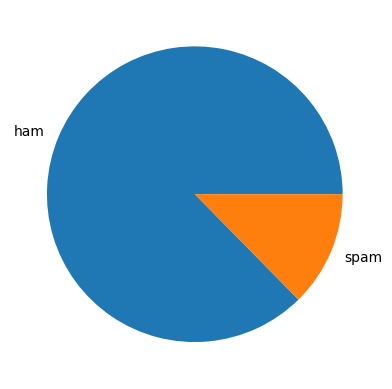

In [18]:

plt.pie(df["target"].value_counts(),labels=['ham','spam'])
plt.show()

In [19]:
# Data is imbalanced 


In [20]:
# Numbers of character in each comment
df["num_characters"]=df["text"].apply(len)

In [21]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
# numbers of Words
df["num_words"]=df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [23]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [24]:
df["num_sentences"]=df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [25]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [26]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
# ham 
df[df['target']==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [28]:
# Spam
df[df['target']==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


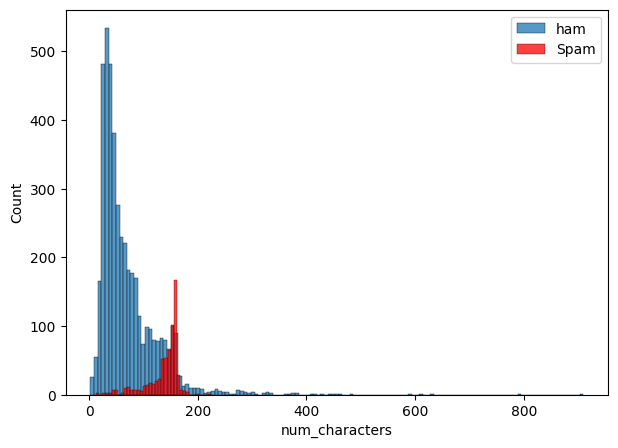

In [29]:
plt.figure(figsize=(7,5))
sns.histplot(df[df['target']==0]['num_characters'],label="ham")
sns.histplot(df[df['target']==1]['num_characters'],color='red',label='Spam')
plt.legend()

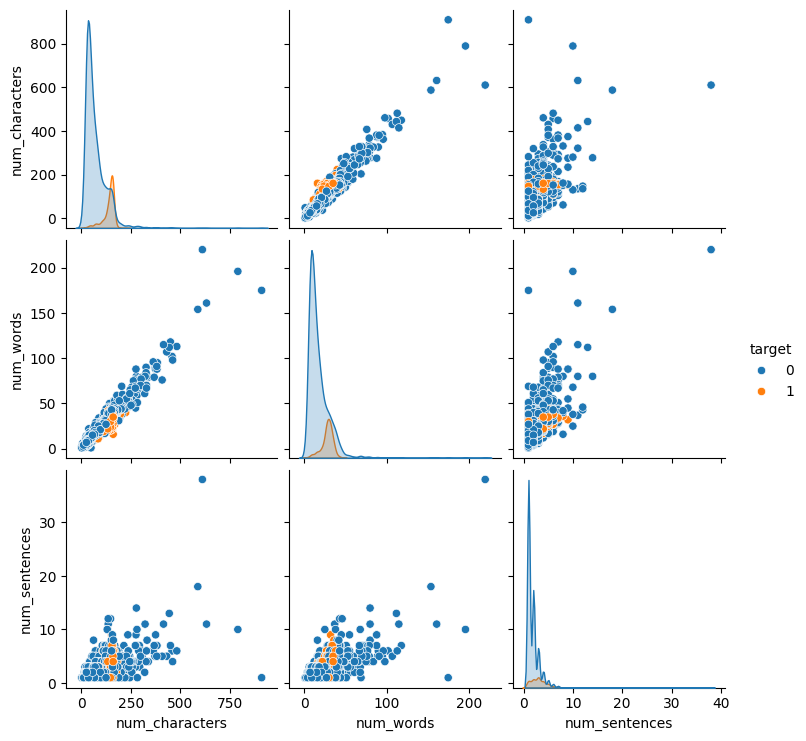

In [30]:
sns.pairplot(df,hue='target')

In [31]:
df.corr(numeric_only=True)

,target,num_characters,num_words,num_sentences
target,1.000000,0.384717,0.262912,0.263939
num_characters,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentences,0.263939,0.624139,0.679971,1.000000


<Axes: >

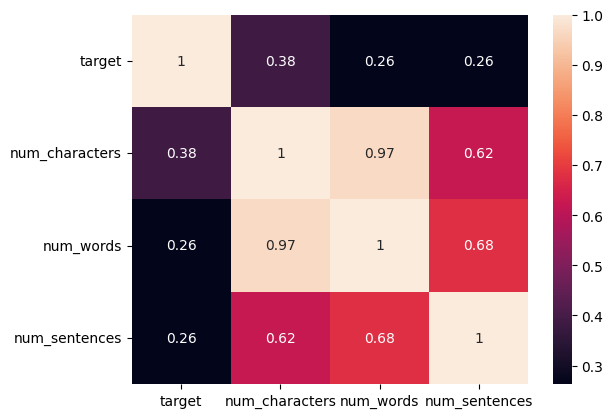

In [32]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

## 4. Data preprocessing

 - Lower Case
 - Tokenization
 - Removing Special Characters
 - Removing stop Words and Punctuation
 - Stemming

In [33]:
ps=PorterStemmer()

In [34]:
def transform_text(text):
    text=text.lower()
    text=nltk.word_tokenize(text)


    #Removing Special Characters
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)

# Removing stop Words and Punctuation
    text=y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
# Stemming
    text=y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
        
    
    return " ".join(y)

In [35]:
transform_text("Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...")

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [36]:
df["transformed_text"]=df['text'].apply(transform_text)

In [37]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [38]:

wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [39]:
spam_wc=wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))

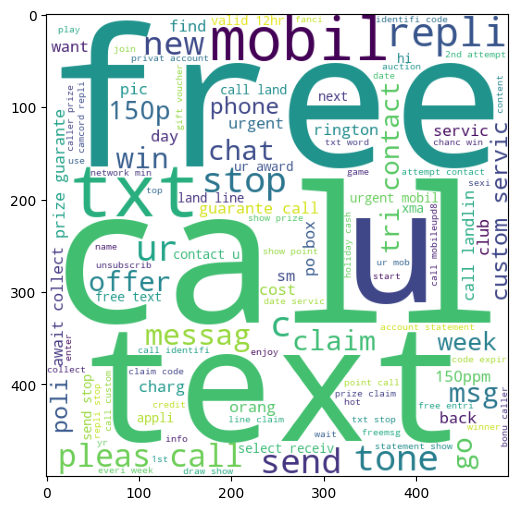

In [40]:
plt.figure(figsize=(12,6))
plt.imshow(spam_wc)
plt.show()

In [41]:
ham_wc=wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))

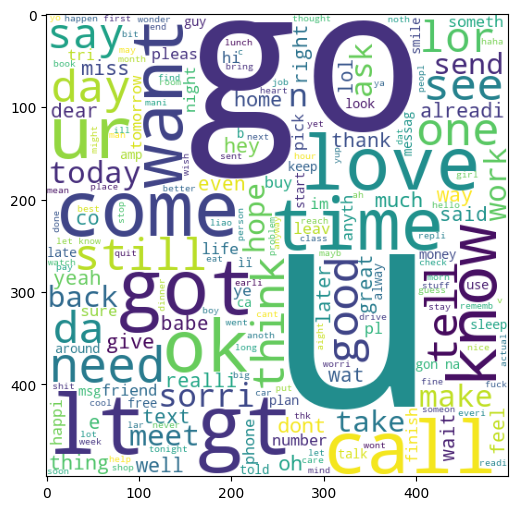

In [42]:
plt.figure(figsize=(12,6))
plt.imshow(ham_wc)
plt.show()

In [43]:
spam_corpus=[]
for msg in df[df['target']==1]['transformed_text'].tolist():
    for words in msg.split():
        spam_corpus.append(words)

In [44]:

Counter(spam_corpus).most_common(30)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

In [45]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist():
    for words in msg.split():
        ham_corpus.append(words)

In [46]:
from collections import Counter
Counter(ham_corpus).most_common(30)

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('call', 233),
 ('time', 219),
 ('ok', 217),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165),
 ('lor', 159),
 ('4', 156),
 ('home', 152),
 ('think', 149),
 ('see', 147),
 ('take', 143),
 ('still', 143),
 ('da', 142),
 ('tell', 133),
 ('make', 129)]

## 5. Model Building

In [47]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [48]:

tfidf=TfidfVectorizer(max_features=3000)

In [49]:
X=tfidf.fit_transform(df['transformed_text']).toarray()

In [50]:
X.shape

(5169, 3000)

In [51]:
y=df['target'].values

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

In [53]:

mnb=MultinomialNB()


In [54]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


## 6. Export Models

In [55]:

pickle.dump(tfidf,open(vectorizer_path,"wb"))
pickle.dump(mnb,open(model_Path,'wb'))